In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from pipeline import AnomalyDetectionPipeline

In [6]:
data = 'data/TOTF.PA-book/2015-01-02-TOTF.PA-book.csv.gz'

# Initialize Pipeline
pipeline = AnomalyDetectionPipeline(seq_length=25, batch_size=128)

# Load Data
nrows = 100_000
pipeline.load_data(data, nrows=nrows)

# Engineer Features
selected_features = ['base', 'tao', 'hawkes', 'poutre']
pipeline.engineer_features(feature_sets=selected_features)

# Preprocess Data
# Train Model
methods = ['minmax', 'box-cox']
models = ['transformer_ocsvm', 'pnn']
metrics = {}
for method in methods:
    pipeline.scale_and_sequence(method=method)
    for model in models:
        pipeline.train_model(model_type=model, epochs=25, lr=1e-3)
        metrics[(method, model)] = pipeline.evaluate()

Pipeline initialized on device: cuda
Loading data from data/TOTF.PA-book/2015-01-02-TOTF.PA-book.csv.gz...
Successfully loaded 100000 rows.
Engineering features: ['base', 'tao', 'hawkes', 'poutre']...
Feature Engineering complete. Total features: 122
Preprocessing with method: minmax...
Dropping['ask-volume-10', 'ask_sweep_cost'] constant features: ['ask-volume-10', 'ask_sweep_cost']
Data split: Train (69982, 25, 120), Test (29993, 25, 120)
Initializing Transformer Autoencoder...
Training Autoencoder...
Epoch 1/25 - Loss: 0.016065
Epoch 2/25 - Loss: 0.007111
Epoch 3/25 - Loss: 0.004569
Epoch 4/25 - Loss: 0.003386
Epoch 5/25 - Loss: 0.002904
Epoch 6/25 - Loss: 0.002613
Epoch 7/25 - Loss: 0.002211
Epoch 8/25 - Loss: 0.001890
Epoch 9/25 - Loss: 0.001647
Epoch 10/25 - Loss: 0.001416
Epoch 11/25 - Loss: 0.001209
Epoch 12/25 - Loss: 0.001060
Epoch 13/25 - Loss: 0.000921
Epoch 14/25 - Loss: 0.000855
Epoch 15/25 - Loss: 0.000735
Epoch 16/25 - Loss: 0.000673
Epoch 17/25 - Loss: 0.000674
Epoch 1

In [7]:
# Result Metrics
results_list = []

for (method, model_type), (scores, cm) in metrics.items():
    row = {
        'Preprocessing': method,
        'Model': model_type,
        'AUROC': scores['AUROC'],
        'AUPRC': scores['AUPRC'],
        'F4 Score': scores['F4_Score']
    }
    results_list.append(row)

results_df = pd.DataFrame(results_list)
print(results_df.round(4))

  Preprocessing              Model   AUROC   AUPRC  F4 Score
0        minmax  transformer_ocsvm  1.0000  1.0000    0.9943
1        minmax                pnn  0.9944  0.9894    0.9978
2       box-cox  transformer_ocsvm  1.0000  1.0000    0.9876
3       box-cox                pnn  0.8790  0.9185    0.4372


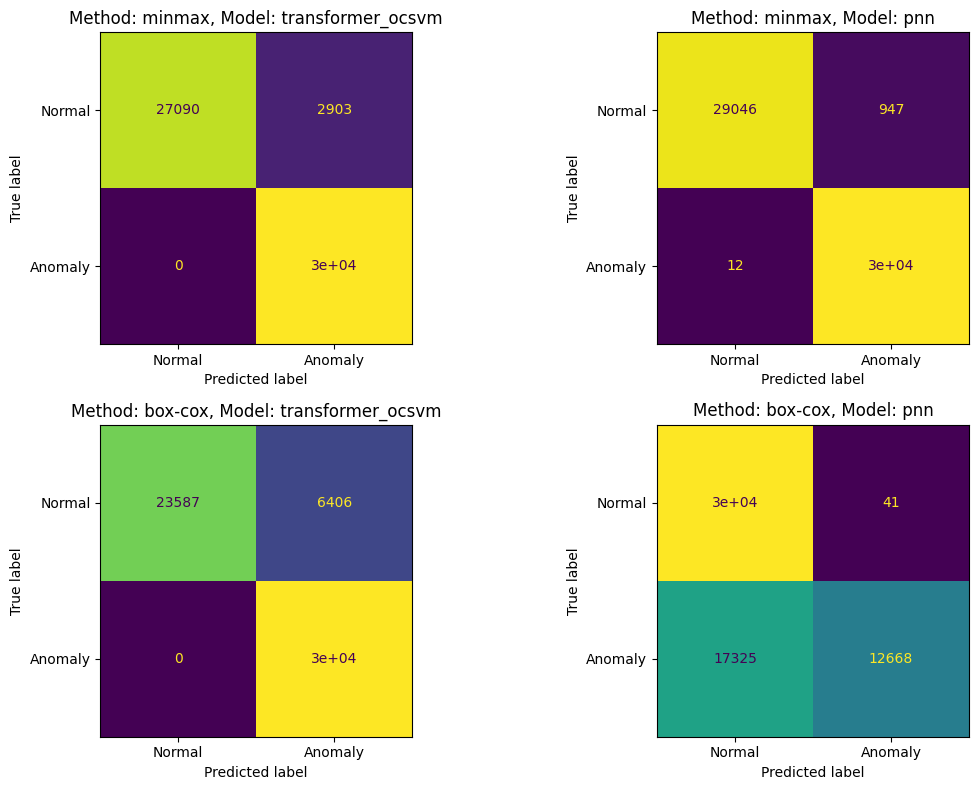

In [8]:
# Plot Confusion Matrices
fig, axes = plt.subplots(len(methods), len(models), figsize=(12, 8))
for i, method in enumerate(methods):
    for j, model in enumerate(models):
        ax = axes[i, j]
        cm = metrics[(method, model)][1]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
        disp.plot(ax=ax, colorbar=False)
        ax.set_title(f'Method: {method}, Model: {model}')


plt.tight_layout()
plt.show()